# Lab 4: Frequency Analysis -- Calibration of the SDR frequency using GSM signals <br>




### Michael Lustig 

#### Note: The instruction in this lab are now less detailed and require some thought and common sense with respect to choosing parameters and implementations. You should probably make sure you plot various temporary results (even though we may not request them) in order to guarentee your code is correct -- like the results of filter design or filtering....

* The lab was inspired by the Kalibrate project by Joshua Lackey

We hope you enjoy it!



In [4]:
# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt, time, IPython.display
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
from scipy import signal 
import pyaudio
import time
%matplotlib inline

In [5]:
# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X**2),axis=0)


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
 
    fig=figure(figsize=(16,6));
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto');
    plt.xlabel('Time, s');
    plt.ylabel('Frequency, Hz');
    plt.tight_layout();
    
def myspectrogram_hann_ovlp(x, m, fs, fc, dbf = 60, fig = None):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    
    # check if x is real
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = fft(xmw,len(xmw),axis=0)
        fig = sg_plot(t_range, f_range, xmf[0:m//2,:], dbf, fig);
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = abs(fftshift( fft( xmw ,len(xmw),axis=0), axes=0 ))
        fig = sg_plot(t_range, f_range, xmf, dbf, fig);
    
    return fig

## RTL-SDR frequency Drift

The rtl-sdr has has a 28.8MHz crystal oscillator, which sets the reference frequency used for demodulation on the tuner. The crystal is known to have poor quallity and therefore its frequency can drift considerably with temperature. The drift is measured in parts per millions (PPM) and can go up to $\pm50$ PPM. The result of such a drift is that when you tune to a certain frequency, you will actually be tunning to an offset frequency. This offset is proportional to the center frequency, so the absolute frequency offset gets worse for higher frequencies. 

This sort of oscillator drifts are very common in other devices, such as your cellphone. The wireless industry has come up with many different techniques in which the clock, or the absolute frequency can be corrected for. In this lab we will use the GSM cellphone network to correct for the frequency drift of the rtl-sdr. GSM base stations are required to have an accurate clock within 0.05 ppm, so they are an excellent source of "accurate" signals.  This is very much the first step that a GSM based phone would do in order to connect to the network. 


Before we start talking about how to use the GSM network to calibrate our rtl-sdr, let's learn a bit about the system


## GSM : Global System for Mobile Communications

This section is heavily based on "GSM for dummies" (http://www.pennula.de/datenarchiv/gsm-for-dummies.pdf)

GSM is a popular digital cellular network. It is based on time-division-multiple-access (TDMA), which means that several phones use the same channel by time interleaving. GSM operates in several different carrier frequencies. In the US and Canada and number of other countries, the frequency bands are 850MHz and 1900MHz. In this lab we will use the 850MHz frequency band, since for the majority of you have the 820T tuner based rtl-sdrs, and the 1900MHz band is outside of its range (28-1700MHz). 

### Frequencies
For the GSM-850 the band is separated into Uplink frequencies 824-849MHz and downlink frequencies 869-894MHz. The base station transmits on the downlink frequencies and mobile phones transmit on the uplink frequencies. GSM operates in duplex mode in which the phones and base stations receive and transmit at the same time. This is the reason that the uplink and the downlink are separated by 50MHz!. A channel number, also known as Absolute Radio Frequency Channel Number (ARFCN) is assigned a pair of uplink and downlink frequencies. There are 124 channels numbered 128-251 in the GSM-850 system. Each channel is allocated a bandwidth of 200KHz. For the downlink frequencies $f_N = 869.2+0.2*(ARFCN-128)$ MHz. 

### Modulation
GSM uses Gaussian Minimum Shift Keying (GMSK in short) as a modulation method. We will cover this in part II of this lab. But, in short.... it is a binary digital Frequency Modulated scheme in which the phase between each bit period is continuouse. Bits are encoded as different frequencies separated by one-half the bit-rate. The modulation rate in GSM is $1625/6 \approx 270.833$ kb/s. For more information read (http://en.wikipedia.org/wiki/Minimum-shift_keying) 

### Time-Division-Multiple-Acess

GSM uses time-division to share a frequency channel among users. Each frequency is divided into blocks of time that are known as time-slots. There are 8 time-slots that are numberes TS0 - TS7. Each time-slot lasts about 576.9 $\mu s$. Given the bit-rate above, a total of 156.25 bits can be transmitted in each slot. Each slot allocates 8.25 of it "bits time" as guard-time, split between the beginning and the end of each time-slot. This time is necessary to prevent overlapping between the different time slots. In addition, 3 bits on both sides of the time-slot do not contain any data and are there to allow for ramping the amplifiers up and down.   

Data transmitted within each time-slot is called a burst. There are several type of burts, with different purposes. We are interested in the  so called "frequency correction" burst, which is a burst of a pure frequency tone at 1/4th the bitrate of GSM or (1625000 / 6) / 4 = 67708.3 Hz. 


<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/lab2/GSM.png" alt="gsm" style="width: 600px;"/></center>
<center>Figure 1: TDMA frames and bursts</center>


### Frame Structure, and Frequency Correction Channel (FCCH)
GSM has hirarchial structure. At the bottom is the burst, which was discussed above, the next is a TDMA frame, which consists of several bursts and the next is a multi-frame, which consists of several frames. 

A TDMA frame consists of 8 time slots and is 4.615ms long. A control channel multi-frame is composed of 51 TDMA frames (numbered 0-50) and is 235.4ms long. A base station transmits a frequency correction burst in regular positions. The frequency correction channel repeats every 51 frames and the burst occurs at the TS0 time-slot in frames 0,10,20,30 and 40 in the control channel multi-frame. 

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/lab2/FCCH.png" alt="gsm" style="width: 800px;"/></center>
<center>Figure 2: Frequency correction bursts at 67708.3Hz are transmitted at time slot TS0 on frames 0,10,20,30 and 40 in a control hannel multi-frame. That sequence repeates every 51 TDMA frames. So the interval between bursts within a frame is 46.15ms, and the interval between the last burst in a frame to the first burst in the next is 50.765ms </center>



If we receive a signal from a base station, we should see these tone bursts at 67.7083KHz offset with respect to the center frequency of the channel. If the frequency offset of the bursts is different than 67.7083KHz, then we can compute its offset and find the correction that is needed to calibrate our software defined radio. 


### Finding a GSM base station

The first thing to do is to find a GSM base station in your area, that has a good steady signal. If you have poor cell reception, you might want to try this near cory hall -- where we were able to pick up a few. Unfortunately, the downlink frequency band is shared with spread-spectrum LTE and 3G stations as well, so detection based on the energy of a signal in a channel is not enough. It is easy to find a base station based on the spectrum shape in the channel and also based on the frequency correction bursts. It is posible to develop  routines in order to do so automatically, but for the sake of simplicity (and time) we will manually search for GSM base station in our area. 

Use either Gqrx or SDR\# to look for GSM base station. Here's a screen shot of GSM and CDMA

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/lab2/spectrum_GSM_CDMA.png" alt="gsm" style="width: 600px;"/></center>
<center>Figure 3: Spectrum of GSM and spread spectrum when sampled at 2MS/s</center>


Here's the average power spectrum as well as the magnitude of the time signal. Note that for GSM, the energy is concentrated towards the center of the spectrum and drops at the edges smoothly. You can also see that we have a considerable amount of frequency offset, because the spectrum is not centered around the right frequency. 

I've searched the spectrum around Cory hall and found the following frequencies to have GSM base stations: 869.2 (med), 869.4 (hi) , 869.6 (low), 874.4 (med), 874.6 (hi), 879.2 (low), 879.4 (med), 879.6 (hi),  879.8 (med), 890.2 (med), 890.4 (med), 890.6 (low), 890.8 (med), 891.0 (hi), 891.4 (med), where (low), (med), (high) are the signal intensity I measured at my office at 5th floor of cory. NOTE: These are good options to try, but reception varies across the building and campus. 


In case you are in a place without GSM basestations, then we recorder some data for you to practice and develop your code on. It can be downloaded from:   https://inst.eecs.berkeley.edu/~ee123/sp14/lab/lab4/gsm.npy

#### Task I: 

* Find a GSM base-station with SDR\# or with Gqrx
* In ipython notebook, collect 25600*3 samples of data at a samping rate of 240KHz. Discard the first 2000 samples as they are generally not valid. 
* Compute the signals's average power spectrum. 
* Display both the power spectrum and a magnitude-time domain section that corresponds to 5ms, which should cover a time period just over 1 TDMA frame length (1200 samples). 
* Can you see 8 TDMA time-slots? You should see the guard time between TDMA frames! 

##### Debug hints
* If your time signal is quantized -- try increasing the gain
* Sometimes, the reference frequency will be way off -- over 60ppm. In that case, your spectrum will be significanly assymmetric around the center. You can use the function `sdr.set_freq_correction(ppm)` to correct for some of the offset. Setting `sdr.set_freq_correction(1)` will shift the spectrum by 880Hz around 880MHz
* If you don't see the TDMA frames, then you may have just too low of an SNR. Place the antenna on a conductive surface, close to a window. 

In [10]:
fs = 240000
fc =  879.347e6 # 1090 MHz center frequency
gain = 32
ppm = 1

# your code here

sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)
# collect data and throw away the first 2000 samples, since they are no good!
data = sdr.read_samples(25600*3)[2048:]
sdr.close()


In [4]:
# In case you don't have a base station, download gsm.npy and uncomment the next line
#data = np.load('gsm.npy')

# throw away the first 2000 samples, since they are no good!
data = data[2048:]

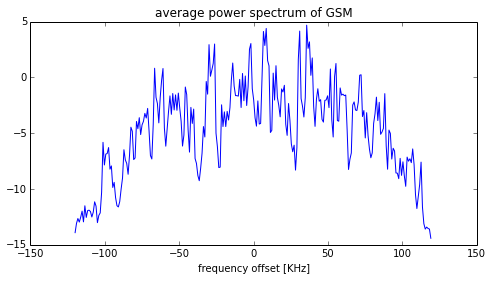

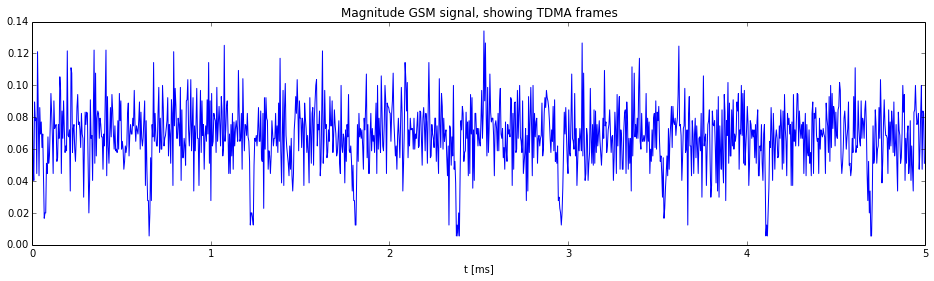

In [108]:
# compute average power spectrum
f, sp = avgPS(data,N=256,fs=fs/1000)
fig = figure(figsize=(8,4))
plot(f,10*log10(sp))
title('average power spectrum of GSM')
xlabel('frequency offset [KHz]')

# plot 
fig = figure(figsize=(16,4))
plot(r_[0:1200.0]/fs*1000,abs(data[:1200]))
title('Magnitude GSM signal, showing TDMA frames')
xlabel('t [ms]')

One way to see the frequency correction bursts is to compute a spectrogram of the signal. This is very effective, though not very computation efficient for the purpose of detecting the bursts. 

* Use the function myspectrogram_hann_ovlp from lab 2 
* For the length of the burst, what length should the spectrogram window be in order to detect the bursts? Play with different parameters. 
* You should be able to see about 6 frequency correction bursts. Also note that in many cases the frequency correction bursts can be 30-50KHz away from where they are supposed to be!

In [7]:
backup_data = np.copy(data)

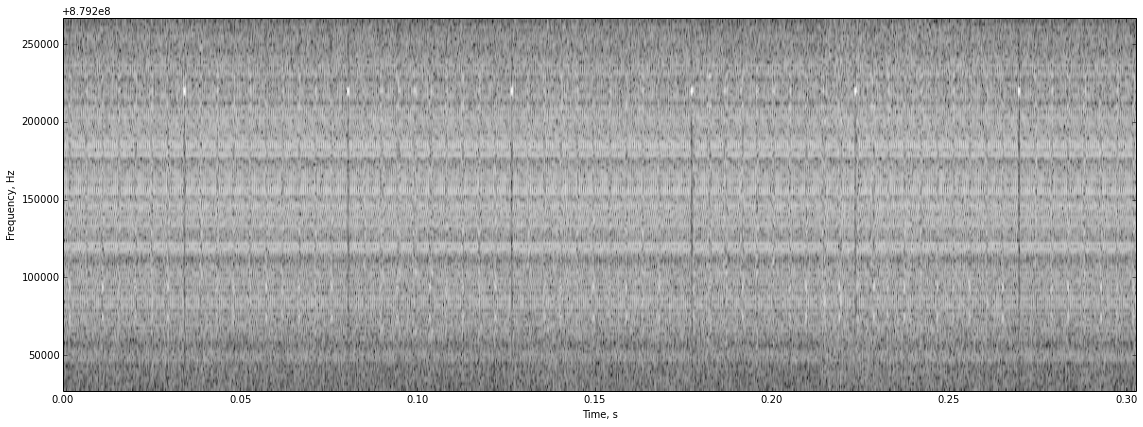

In [6]:
# Your code here
m = 128 # window length
myspectrogram_hann_ovlp(data,m,fs,fc)

### Finding the FCCH bursts and computing the frequency offset

There are many methods for robust frequency correction for GSM.  The approach we will take here is using an envelope detection over a frequency band to detect the position in time of the FCCH bursts. Once the the samples of a burst are recognized, we can use the DFT to calculate the frequency offset. Magnitude averaging over several bursts will give us a more robust estimation of the offset. 

Of course, there are going to be many tradeoffs in the design. For example, to be able to distinguish the burst from noise, and the rest of the GSM signal, we would like to use a narrow-band filter. However, because of the frequency offset the FCCH burst might be outside of our filter bandwwidth and we will miss it! We can solve this in general by using a filter-bank to cover all the possible range of frequency drifts. In addition, narrow-band filters require many filter taps for selectivity. We can save some computation by using decimating filters -- so the detection can be performed at a lower rate. A polyphase implementation of these filters would also be efficient, though you are probably not going to observe much improvements in the python environment. 

For simplicity,  in this lab, we will use one narrow-band filter, not a filter bank. To make sure we are looking at the right range,  look at the spectrogram above. You should have a good idea what is the offset of the FCCH bursts. 

#### Task II:
* Calculate the length of a FCCH burst in samples for 240KHz sampling rate. What is it?
* Find the approximate frequency of the FCCH burst from the spectrogram (you need to be accurate up to $\pm 7.5KHz$) and record it as the $f_{cc}$ (no punn intended). In the ideal case of no frequency offset it should be  67.7083KHz.
* Demodulate the GSM signal by $f_{cc}$ to bring that offset frequency down to DC.
###* Design a low-pass filter with a pass-band bandwidth of $\pm7.5$KHz. The number of taps should be odd and correspond roughly to the length of the FCCH burst. What is the TBW product of the filter in that case?? (TBW or Time-Bandwidth product is the product of the length of the filter (in seconds) multiplied with the filter's bandwidth (in Hz) and hence unitless)

* Filter and decimate the data. and plot the magnitude of the result, can you see the FCCH burts?

##### Debug hints:
* You should clearly see 6 pulses, if you don't, then the pulses are not within your filter bandwidth



In [ ]:
# TBW = 141*15k = 2115k

In [63]:
# Your code here
# sampling rate fs = 240e3 samples/second
burst_t = 576.9e-6 #seconds
burst_len = 1 + fs*burst_t//1 # == 139 samples
fcc = fc + 640000 # approximate frequency of the FCCH burst
demod_data = np.exp(-1j * fcc * np.linspace(0,len(data),len(data)))*data

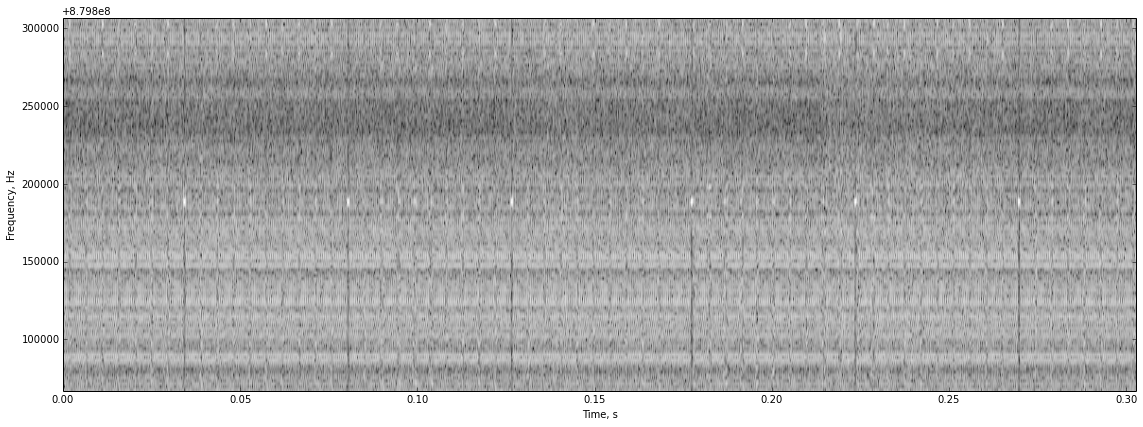

In [64]:
myspectrogram_hann_ovlp(demod_data, 128, fs, fcc)

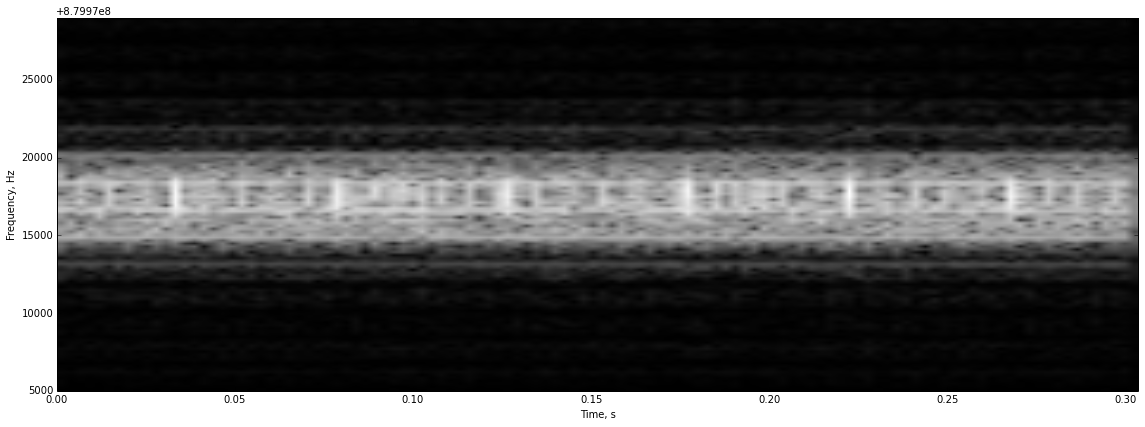

In [107]:
h = signal.firwin(141,7500,nyq=2400000.0/2,window='hanning')
filtered_data = signal.fftconvolve(demod_data, h)[::10]
myspectrogram_hann_ovlp(filtered_data, 128, fs/10, fcc)

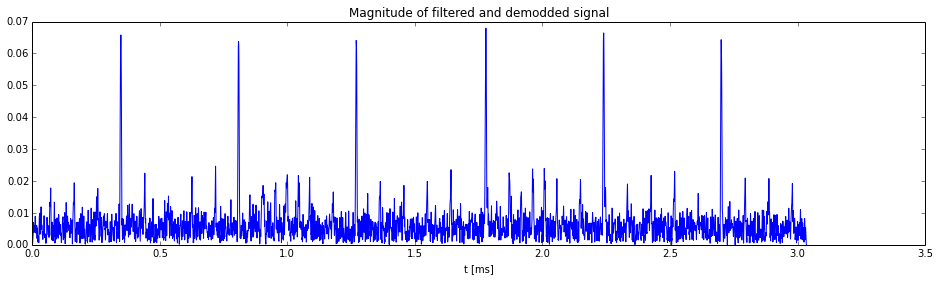

In [118]:
fig = figure(figsize=(16,4))
plot(r_[0:len(filtered_data)]/fs*100, abs(filtered_data))
title('Magnitude of filtered and demodded signal')
xlabel('t [ms]')

The next step is to detect the position of the FCCH bursts in time and compute their frequency. 

* Write a function that will take the signal and its sampling rate as an input. The function will find the location of the FCCH bursts, and return the starting and ending indexes of each burst within the input array. (You should know the length of each burst from the sampling rate!)

There are many ways to detect bursts, ... we leave that as a design challenge for you. Some approaches might be more robust then others. 

* Apply the function on the decimated signal to obtain the FCCH bursts positions.


##### Debug hints
* debug well that you are actually detecting the bursts!!!




In [6]:
def locateBurst(x, fs):
    #  fcch_idx_pos = locateBurst ( x, fs) 
    #  function to find the starting and ending FCCH bursts in a given signal segment
    #  Inputs:
    #           x  - signal array
    #           fs - sampling frequency
    #
    #  Outputs:
    #           fcch_idx_pos and N x 2 array in which each row represents starting and ending indexes of bursts
    #
    
    burst_t = 576.9e-6 #seconds
    half_len = fs*burst_t//2 + 3

    normed = (abs(x)/max(abs(x)))**2
    normed[normed < 0.5] = 0
    
    pulses = []
    for i in range(len(normed)-2):
        if normed[i+1]>normed[i] and normed[i+1]>normed[i+2]:
            if(i-half_len < 0 or i+half_len >= len(normed)-2):
                continue
            else:
                pulses += [(i+1-half_len, i+1+half_len)]

    return np.array(pulses)   
            
  


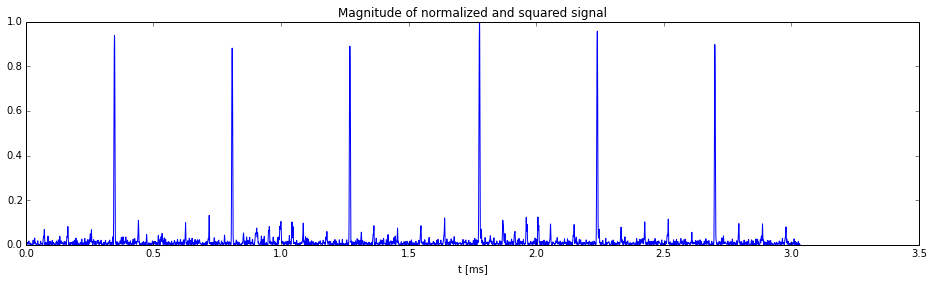

In [333]:
# Your test code here
fig = figure(figsize=(16,4))
plot(r_[0:len(filtered_data)]/fs*100, (abs(filtered_data)/max(abs(filtered_data)))**2)
title('Magnitude of normalized and squared signal')
xlabel('t [ms]')

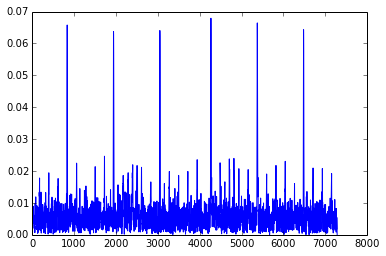

In [457]:
plt.plot(abs(filtered_data))

In [455]:
pos = locateBurst(filtered_data,fs/10)

In [456]:
pos

array([[  824.,   842.],
       [ 1931.,  1949.],
       [ 3038.,  3056.],
       [ 4259.,  4277.],
       [ 5367.,  5385.],
       [ 6472.,  6490.]])

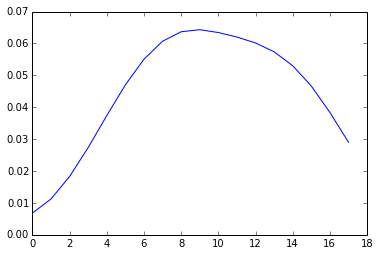

In [454]:
plt.plot(abs(filtered_data)[pos[5][0]:pos[5][1]])

Now that we detected the bursts, we can extract just bursts signals and compute their frequency by finding the peak of a zero-padded DFT. 

Of course there are several bursts in our segment. We can combine the estimates by computing the mean power spectrum of all the bursts and then 
##extract the frequency by finding the peak in the mean power spectrum.

* Write a function that will take the signal, the FCCH burst positions, the demodulation frequency of our estimated FCCH (i.e., $f_{cc}$) and the bandwidth of the decimated signal. The function will extract the segments of the FCCH bursts, zero-pad them appropriately to get a frequency resolution of 10Hz. The function will then find the actual frequency of the FCCH bursts from the average power spectrum of the DFTs, and calculate the actual offset with respect to 67.7083KHz. 



In [7]:
def findOffset(data, fcch_pos, fcc, nbw, disp=0):
    # freq = findFreq ( data, fcch_pos, fcc, nbw, disp=0)
    #
    # The function takes the signal the FCCH burst positions, the center frequency of the filter and 
    # the bandwidth of the decimated signal. The function extracts the segments of the FCCH bursts, 
    # zero-pad them appropriately, finds the actual frequency of the FCCH bursts within the decimated signal,
    # and calculate the actual frequency.
    # Inputs:
    #        data - an array of data
    #        fcch_pos - positions of fcch bursts generated by locateBurst
    #        fcc   - estimated fcch frequency, which you used to demodulate the data
    #        nbw  -   sampling rate of the data
    #        disp -  optimally display the average power spectrum
    #
    # Outputs:
    #       offset - The estimated frequency offset with respect to ideal fcch frequency.
    L = nbw/10 # for fft res = 10 Hz
    
    ffts = []
    for i in range(len(fcch_pos)):
        ffts += [np.fft.fft(append(data[fcch_pos[i][0]:fcch_pos[i][1]], zeros(L-(fcch_pos[i][1]-fcch_pos[i][0]))))]
    mean_power = np.mean(np.fft.fftshift(abs(np.array(ffts)))**2, axis=0)
    idx = np.argmax(mean_power)
    fcch = idx*(nbw/L)
    
    if disp:
        plt.figure()
        plt.plot(mean_power)
        title('average power spectrum of DFTs')
        xlabel('frequency offset [KHz]')
   
    return (fcch) - (1625000.0 / 6.0) / 4.0  

* Apply the function on your data to find the frequency offset.


##### Debug hints
* try displaying the power spectrum, or even an image showing all the individual burst power spectrum's intensity

56421.6666667


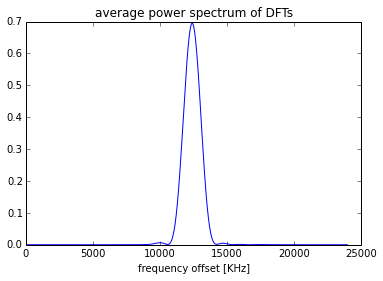

In [515]:
# Your code here
offset = findOffset(filtered_data, pos, fcc,fs,1)
print(offset)



* what is the shift in  PPM?


In [517]:
# Your code here
offset / (fcc + (1625000.0 / 6.0) / 4.0)*1e6

64.111544580585502

Fantastic! now, you have found the offset in PPM, you can set the driver of the rtlsdr to correct for this offset by using the 
`sdr.set_freq_correction(-ppm)` instruction. The negative sign is because of your offset was -1ppm, you should tell the sdr to compensate by setting its offset to +1ppm. Unfortunately, the driver only accepts integer ppm corrections, so you can only set it to the closes integer value. 


Task: 
Write a new function, `Kalibrate(Nmframes, fc, fs,gain, fcc, ppm, h_bw)`,  which automates all the above. 
* It acquires number of samples (must be divisible by 256!!!!!) corresponding to a time closest to `Nmframe * 235.4ms`, which is effectively collecting `Nmframe` number of multi-frames worth of data. It collects them with sdr settings of center frequency `fc`, sampling rate of `fs`, frequency correction offset in ppm of `ppm`, and gain of `gain`. The function also takes the estimate FCCH frequency `fcc` and the filter bandwidth `h_bw`. 
* The function return the frequency offset in hz, and in ppm.


Debug your function well!




In [15]:
def Kalibrate(Nmframe, fc, fs, ppm, gain, fcc, h_bw, disp=0):
    # (offset, ppm) = Kalibrate(Nmframe, fc, fs,ppm,gain, fcc, h_bw, disp=0)
    #
    # Inputs:
    #        Nmfram - number of multi-frames length of data to acquire
    #        fc -  center frequency of the sdr driver
    #        fs -  the sampling rate of the sdr driver
    #        ppm -  the frequency correction in ppm for the sdr driver
    #        gain - gain of the sdr driver
    #        fcc   - estimated fcch frequency, which you used to demodulate the data
    #        h_bw  -   Bandwidth of the low-pass filter
    #        disp -  optinally display the average power spectrum
    #
    # Outputs:
    #       offset - The estimated frequency offset with respect to ideal fcch frequency. 
    #       ppm    - frequency offset in ppm

    sdr = RtlSdr()
    sdr.sample_rate = fs    # sampling rate
    sdr.gain = gain
    sdr.center_freq = fc
    sdr.set_freq_correction(ppm) # +1
    duration = Nmframe*235.4*.001
    num_samples = (duration*fs+2048)//256 * 256
    print('num samples = ' + str(num_samples))
    
    # collect data and throw away the first 2000 samples, since they are no good!
    data = sdr.read_samples(num_samples)[2048:]
    sdr.close()

    demod_data = np.exp(-1j * fcc * np.linspace(0,len(data),len(data)))*data
    h = signal.firwin(141,h_bw/2,nyq=fs/2,window='hanning')
    filtered_data = signal.fftconvolve(demod_data, h)[::10]
    
    offset = findOffset(filtered_data, locateBurst(filtered_data,fs/10), fcc, fs, disp)   
    
    return (offset, offset / (fc + (1625000.0 / 6.0) / 4.0)*1e6)

num samples = 58368.0
(17091.666666666672, 19.435274967209494)


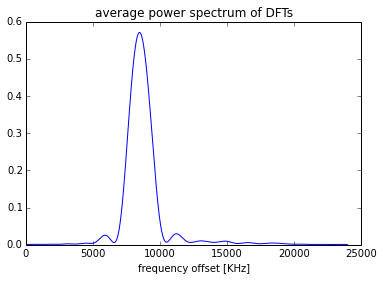

In [21]:
# Your debug code here
offset = Kalibrate(1, fc, fs,ppm,gain, (1625000.0 / 6.0) / 4.0, 15000,disp=1)
print(offset)

##### Task:
Track the frequency drift by calling Kalibrate consequitively for about 4 minutes. Plot the frequency drift in Hz as a function of time. To record the time, record the value of `time.time()` before each call to Kalibrate. Can you see the effect of the heating of the crystal oscilator as the chip is being used? Try blowing air on the sdr, to see the effect on the frequency drift. 



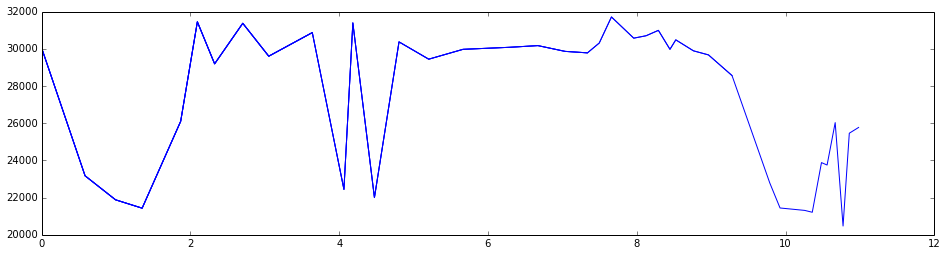

num samples = 284416.0


KeyboardInterrupt: 

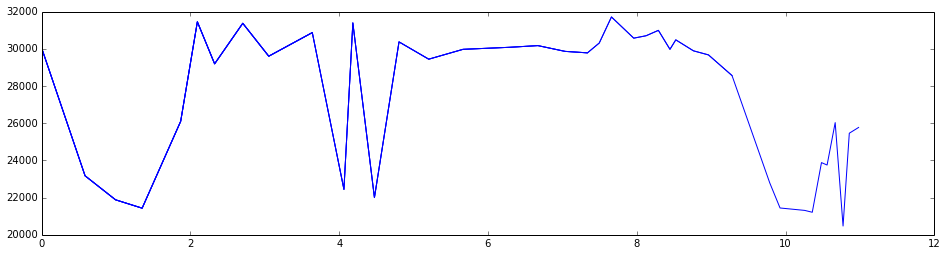

In [23]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

# fs = 240000
# fc = 
# Ndata = 1
# gain = 
# ppm = ;


t = np.zeros(300)
fset=np.zeros(300)

fig = figure(figsize=(16,4))
for n in r_[0:300]:
    t[n]=time.time()
    fset[n] = Kalibrate(Ndata, fc, fs,ppm, gain, (1625000.0 / 6.0) / 4.0, 15000,disp=0)[0]
    
    if n % 10 == 0:
        pl.plot((t[:n]-t[0])/60.0,fset[:n],'b')
        display.clear_output(wait=True)
        display.display(pl.gcf())
fig = figure(figsize=(16,4))
plt.plot((t[:n]-t[0])/60.0,fset[:n])